In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

df = pd.read_csv(os.path.join("eDo", 'data', 'm1.csv'), header=None, names=['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume'], index_col=0, parse_dates=True)

print(df.head())
print(df.info())
print("missing:\n",df.isnull().sum())

df = df.drop_duplicates()
df = df.sort_index()

                         Open      High       Low     Close    Volume
DateTime                                                             
2022-01-01 00:00:00  46216.93  46271.08  46208.37  46250.00  40.57574
2022-01-01 00:01:00  46250.00  46344.23  46234.39  46312.76  42.38106
2022-01-01 00:02:00  46312.76  46381.69  46292.75  46368.73  51.29955
2022-01-01 00:03:00  46368.73  46391.49  46314.26  46331.08  30.45894
2022-01-01 00:04:00  46331.07  46336.10  46300.00  46321.34  20.96029
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1541132 entries, 2022-01-01 00:00:00 to 2024-12-09 07:39:00
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   Open    1541132 non-null  float64
 1   High    1541132 non-null  float64
 2   Low     1541132 non-null  float64
 3   Close   1541132 non-null  float64
 4   Volume  1541132 non-null  float64
dtypes: float64(5)
memory usage: 70.5 MB
None
missing:
 Open      0
High      0
Low       0


### Resample

In [2]:
df = df.resample('1h').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

df[['Open', 'High', 'Low', 'Close']] = df[['Open', 'High', 'Low', 'Close']].ffill()

df['Volume'] = df['Volume'].fillna(0)


In [3]:
expected_hours = pd.date_range(start=df.index.min(), end=df.index.max(), freq='1H')
missing_hours = expected_hours.difference(df.index)
print("Number of missing hours:", len(missing_hours))
if len(missing_hours) > 0:
    print("Missing hours:\n", missing_hours)


Number of missing hours: 0


/tmp/ipykernel_49947/3894954343.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected_hours = pd.date_range(start=df.index.min(), end=df.index.max(), freq='1H')


In [9]:
duplicates = df.index[df.index.duplicated()]
print("Number of duplicates:", len(duplicates))
if len(duplicates) > 0:
    print("Duplicate timestamps:\n", duplicates)


Number of duplicates: 0


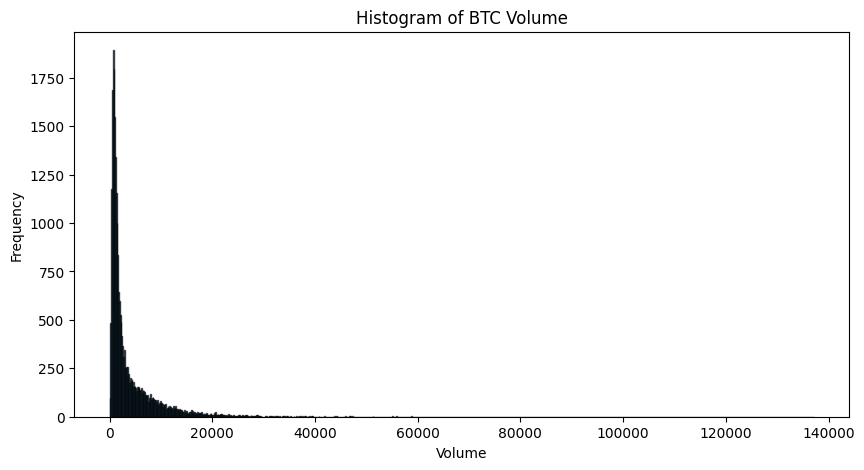

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df['Volume'], bins=900, edgecolor='k', alpha=0.7)
plt.title("Histogram of BTC Volume")
plt.xlabel("Volume")
plt.ylabel("Frequency")
plt.show()


### EDA

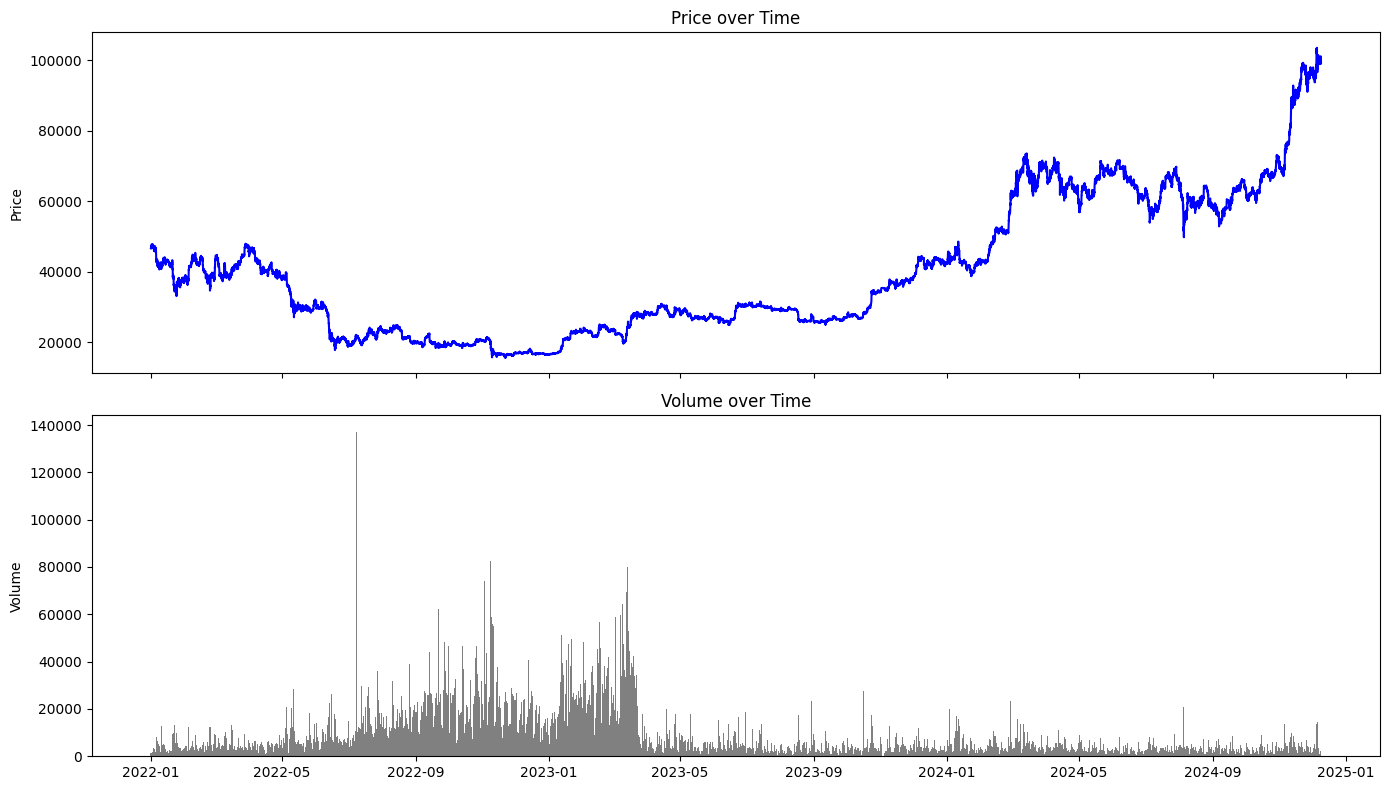

ADF Statistic: 1.1981
p-value: 0.9960
Fail to reject H0 - Series is likely non-stationary.


In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax1.plot(df.index, df['Close'], label='Close', color='blue')
ax1.set_title('Price over Time')
ax1.set_ylabel('Price')

ax2.bar(df.index, df['Volume'], label='Volume', color='gray')
ax2.set_title('Volume over Time')
ax2.set_ylabel('Volume')

ax1.legend().remove()
ax2.legend().remove()

plt.tight_layout()
plt.show()

# ADF test
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Close'])
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')

if result[1] < 0.05:
    print("Reject H0 - Series is likely stationary.")
else:
    print("Fail to reject H0 - Series is likely non-stationary.")



## Stationarity and differentiation

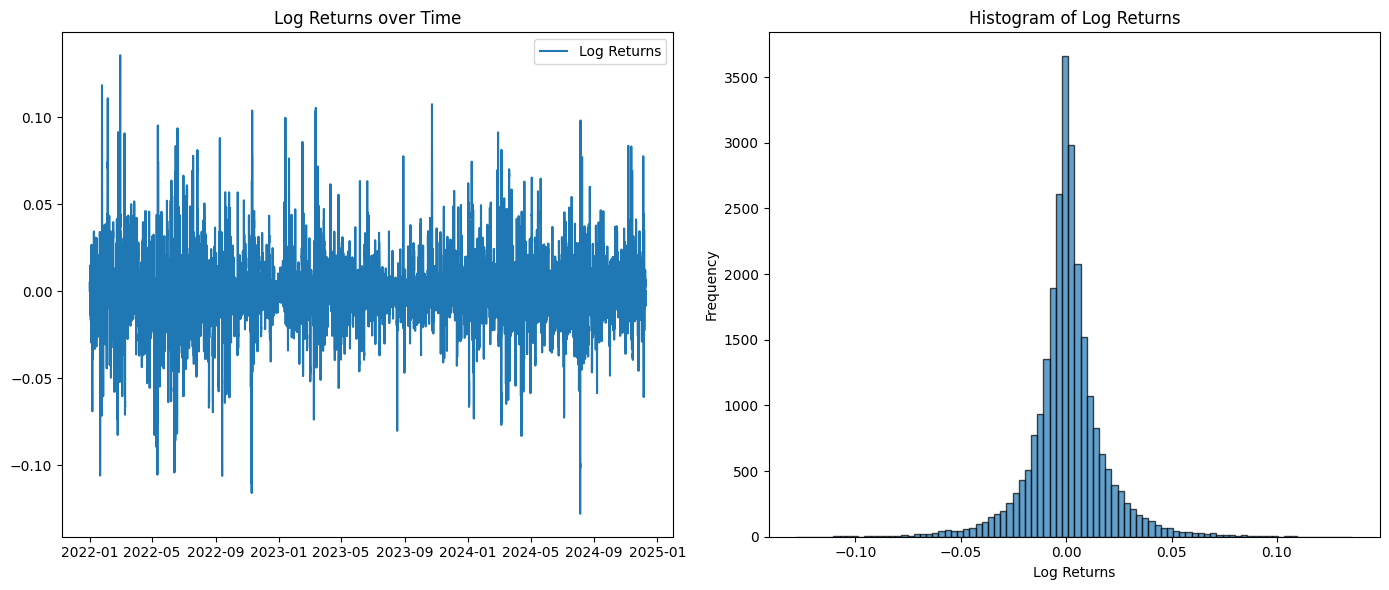

ADF Statistic: -21.5712
p-value: 0.0000
Reject H0 - Series is likely stationary.


In [4]:
df['log_ret'] = np.log(df['Close'] / df['Close'].shift(1))
df['log_ret'] = df['log_ret'].fillna(0)

plt.figure(figsize=(14, 6))

# Time series plot
plt.subplot(1, 2, 1)
plt.plot(df['log_ret'], label='Log Returns')
plt.title('Log Returns over Time')
plt.legend()

# Histogram
plt.subplot(1, 2, 2)
plt.hist(df['log_ret'], bins=90, edgecolor='k', alpha=0.7)
plt.title('Histogram of Log Returns')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# ADF test
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['log_ret'].dropna())
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')

if result[1] < 0.05:
    print("Reject H0 - Series is likely stationary.")
else:
    print("Fail to reject H0 - Series is likely non-stationary.")


This seems a bit too much, perhaps we could perserve some memory while retaining stationarity...

### Fractional differentiation

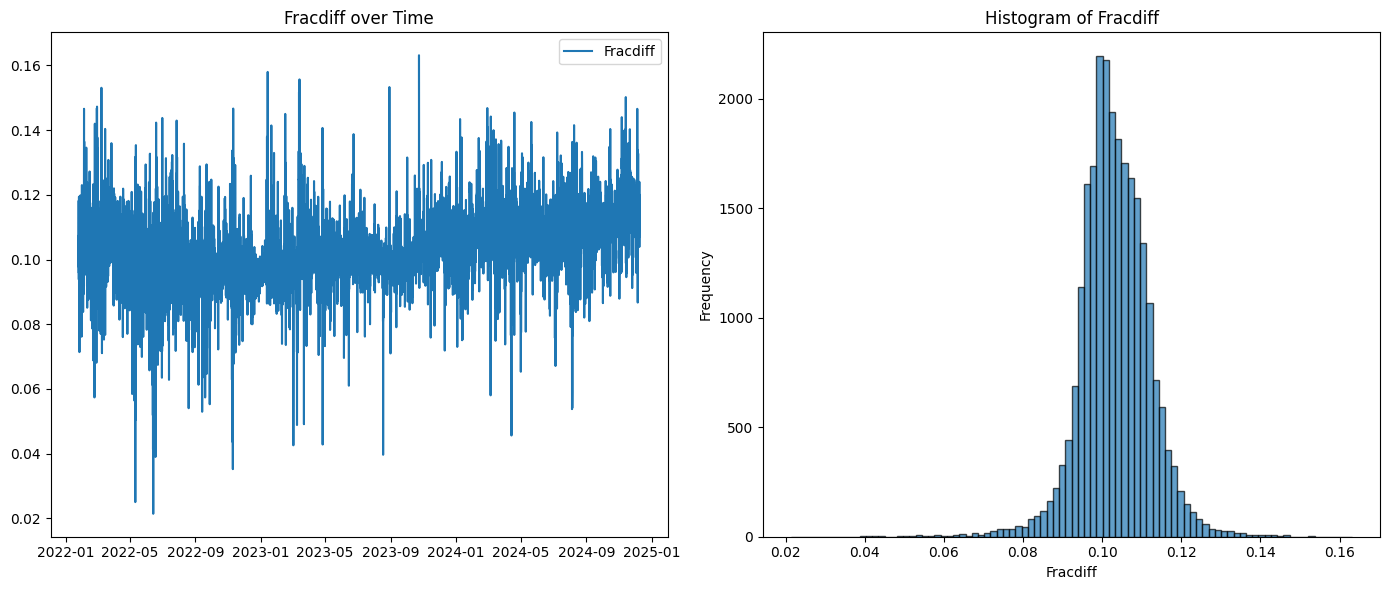

ADF Statistic: -8.1810
p-value: 0.0000
Reject H0 - Series is likely stationary.


In [11]:
def get_weights_ffd(d, thres=1e-5):
    """
    Compute weights for fixed-width fractional differencing.
    :param d: Differencing order, float in (0,1)
    :param thres: Threshold to truncate weights
    :return: List of weights
    """
    w = [1.0]
    k = 1
    # While the next weight is larger than threshold, keep computing
    while True:
        w_ = -w[-1] * (d - k + 1) / k
        if abs(w_) < thres:
            break
        w.append(w_)
        k += 1
    return np.array(w[::-1])  # Return in reverse order

def frac_diff_ffd(series, d, thres=1e-5):
    """
    Fractional differencing for a time series using fixed-width window.
    :param series: Pandas Series of prices
    :param d: Differencing order, float in (0,1)
    :param thres: Threshold to truncate weights
    :return: Pandas Series of fractionally differenced data
    """
    # 1) Get weights
    w = get_weights_ffd(d, thres)
    width = len(w)
    # 2) Apply convolution
    # On each t, we do a dot product of weights with the slice of the series
    results = []
    for i in range(width, len(series)+1):
        window_data = series.iloc[i-width:i].values
        results.append(np.dot(w, window_data))
    # 3) Align output with original index
    frac_diff_series = pd.Series(data=results, index=series.index[width-1:])
    return frac_diff_series


d_value = 0.6  # fractional differencing parameter
df['fracdiff'] = frac_diff_ffd(np.log(df['Close']), d=d_value).ffill()


plt.figure(figsize=(14, 6))

# Time series plot
plt.subplot(1, 2, 1)
plt.plot(df['fracdiff'], label='Fracdiff')
plt.title('Fracdiff over Time')
plt.legend()

# Histogram
plt.subplot(1, 2, 2)
plt.hist(df['fracdiff'], bins=90, edgecolor='k', alpha=0.7)
plt.title('Histogram of Fracdiff')
plt.xlabel('Fracdiff')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

from statsmodels.tsa.stattools import adfuller

result = adfuller(df['fracdiff'].dropna())
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')

if result[1] < 0.05:
    print("Reject H0 - Series is likely stationary.")
else:
    print("Fail to reject H0 - Series is likely non-stationary.")


In [13]:
df.to_csv(os.path.join("eDo", 'data', 'processed.csv'), index=True) 

# Todo
- rolling window fracdiff